In [1]:
from train import train_epochs
from gan_sn import Generator, Discriminator
# from utils.utils import *
from utils.exp1 import experiment_save_results, visualize_experiment_dataset, experiment_data
import utils.pytorch_utils as ptu

from utils.utils import savefig
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import numpy as np
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
from torch.optim.lr_scheduler import StepLR
import time

/Users/maximzubkov/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/maximzubkov/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def penalty(g, d, real_data, fake_data):
    batch_size = real_data.shape[0]

    eps = torch.rand(batch_size, 1).to(ptu.device)
    interpolated = eps * real_data.data + (1 - eps) * fake_data.data
    interpolated.requires_grad = True

    d_output = d(interpolated)
    gradients = torch.autograd.grad(outputs=d_output, inputs=interpolated,
                                    grad_outputs=torch.ones(d_output.size()).to(ptu.device),
                                    create_graph=True, retain_graph=True)[0]

    l2 = (d_output.reshape(-1) ** 2).mean()
    gradients = gradients.reshape(batch_size, -1)
    gradients_norm = torch.sum(gradients ** 2, dim=1)
    return l2 + gradients_norm.mean() / (4 * np.pi)

In [3]:
g = {}
c = {}

In [4]:
n_modes = 3
params = [(2, 0.4),(0, 0.55),(5, 0.25)]

In [5]:
delta = {}

In [6]:
for n_cr in [2]:
    def exp1(train_data):
        loader_args = dict(batch_size=64, shuffle=True)
        train_loader = data.DataLoader(train_data, **loader_args)

        g[n_cr] = Generator(3, 3, 100, 1).to(ptu.device)
        c[n_cr] = Discriminator(1, 3, 100, 1).to(ptu.device)

        # wasserstein
        def g_loss(generator, critic, x):
            fake_data = generator.sample(x.shape[0])
            return - critic(fake_data).mean()

        def c_loss(generator, critic, x):
            fake_data = generator.sample(x.shape[0])
            return critic(fake_data).mean() - critic(x).mean() # + 0.1 * penalty(generator, critic, x, fake_data)
        n_epochs = 50
        c_opt = optim.Adam(c[n_cr].parameters(), lr=9e-5, betas=(0, 0.9))
        g_opt = optim.Adam(g[n_cr].parameters(), lr=9e-5, betas=(0, 0.9))
#         c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=300, gamma=0.9)
#         g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=50, gamma=0.9)
        train_args = {
            "epochs": n_epochs, 
            "n_critic": n_cr, 
            "final_snapshot":True,
        }
        result = train_epochs(g[n_cr], c[n_cr], g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                              c_opt=c_opt, is_spiral=False, modes=n_modes, name=f"sn_ncr{n_cr}", param_modes=params) #, g_scheduler=g_scheduler, c_scheduler=c_scheduler)
        train_losses, samples_1, samples_final = result
        return g[n_cr], c[n_cr], train_losses, samples_1, samples_final

    start = time.time()
    g[n_cr], c[n_cr], train_losses, samples_1, samples_final = experiment_save_results('a', exp1, f"sn_ncr{n_cr}", 
                                                                           is_spiral=False,
                                                                           modes=n_modes,
                                                                           param_modes=params)
    end = time.time()
    delta[n_cr] = end-start
    np.save(f"results/sn_ncr{n_cr}/data", train_losses["pvals"])

AttributeError: 'NoneType' object has no attribute 'data'

In [ ]:
plt.figure(figsize=(20, 10))
plt.title("SNGAN p-value", fontsize=45)
for n_cr in [2, 4, 6]:
    plt.semilogy(np.load(f"results/sn_ncr{n_cr}/data.npy"), label="$n_{cr}= $"+f" {n_cr}")
    plt.xlabel('Training Iteration',fontsize=42)
    plt.ylabel('P-value',fontsize=42)
    plt.tick_params(axis="x", labelsize=40)
    plt.tick_params(axis="y", labelsize=40)
plt.grid()
plt.legend(fontsize=30)
    
savefig("results/compare_pval_sn.pdf")

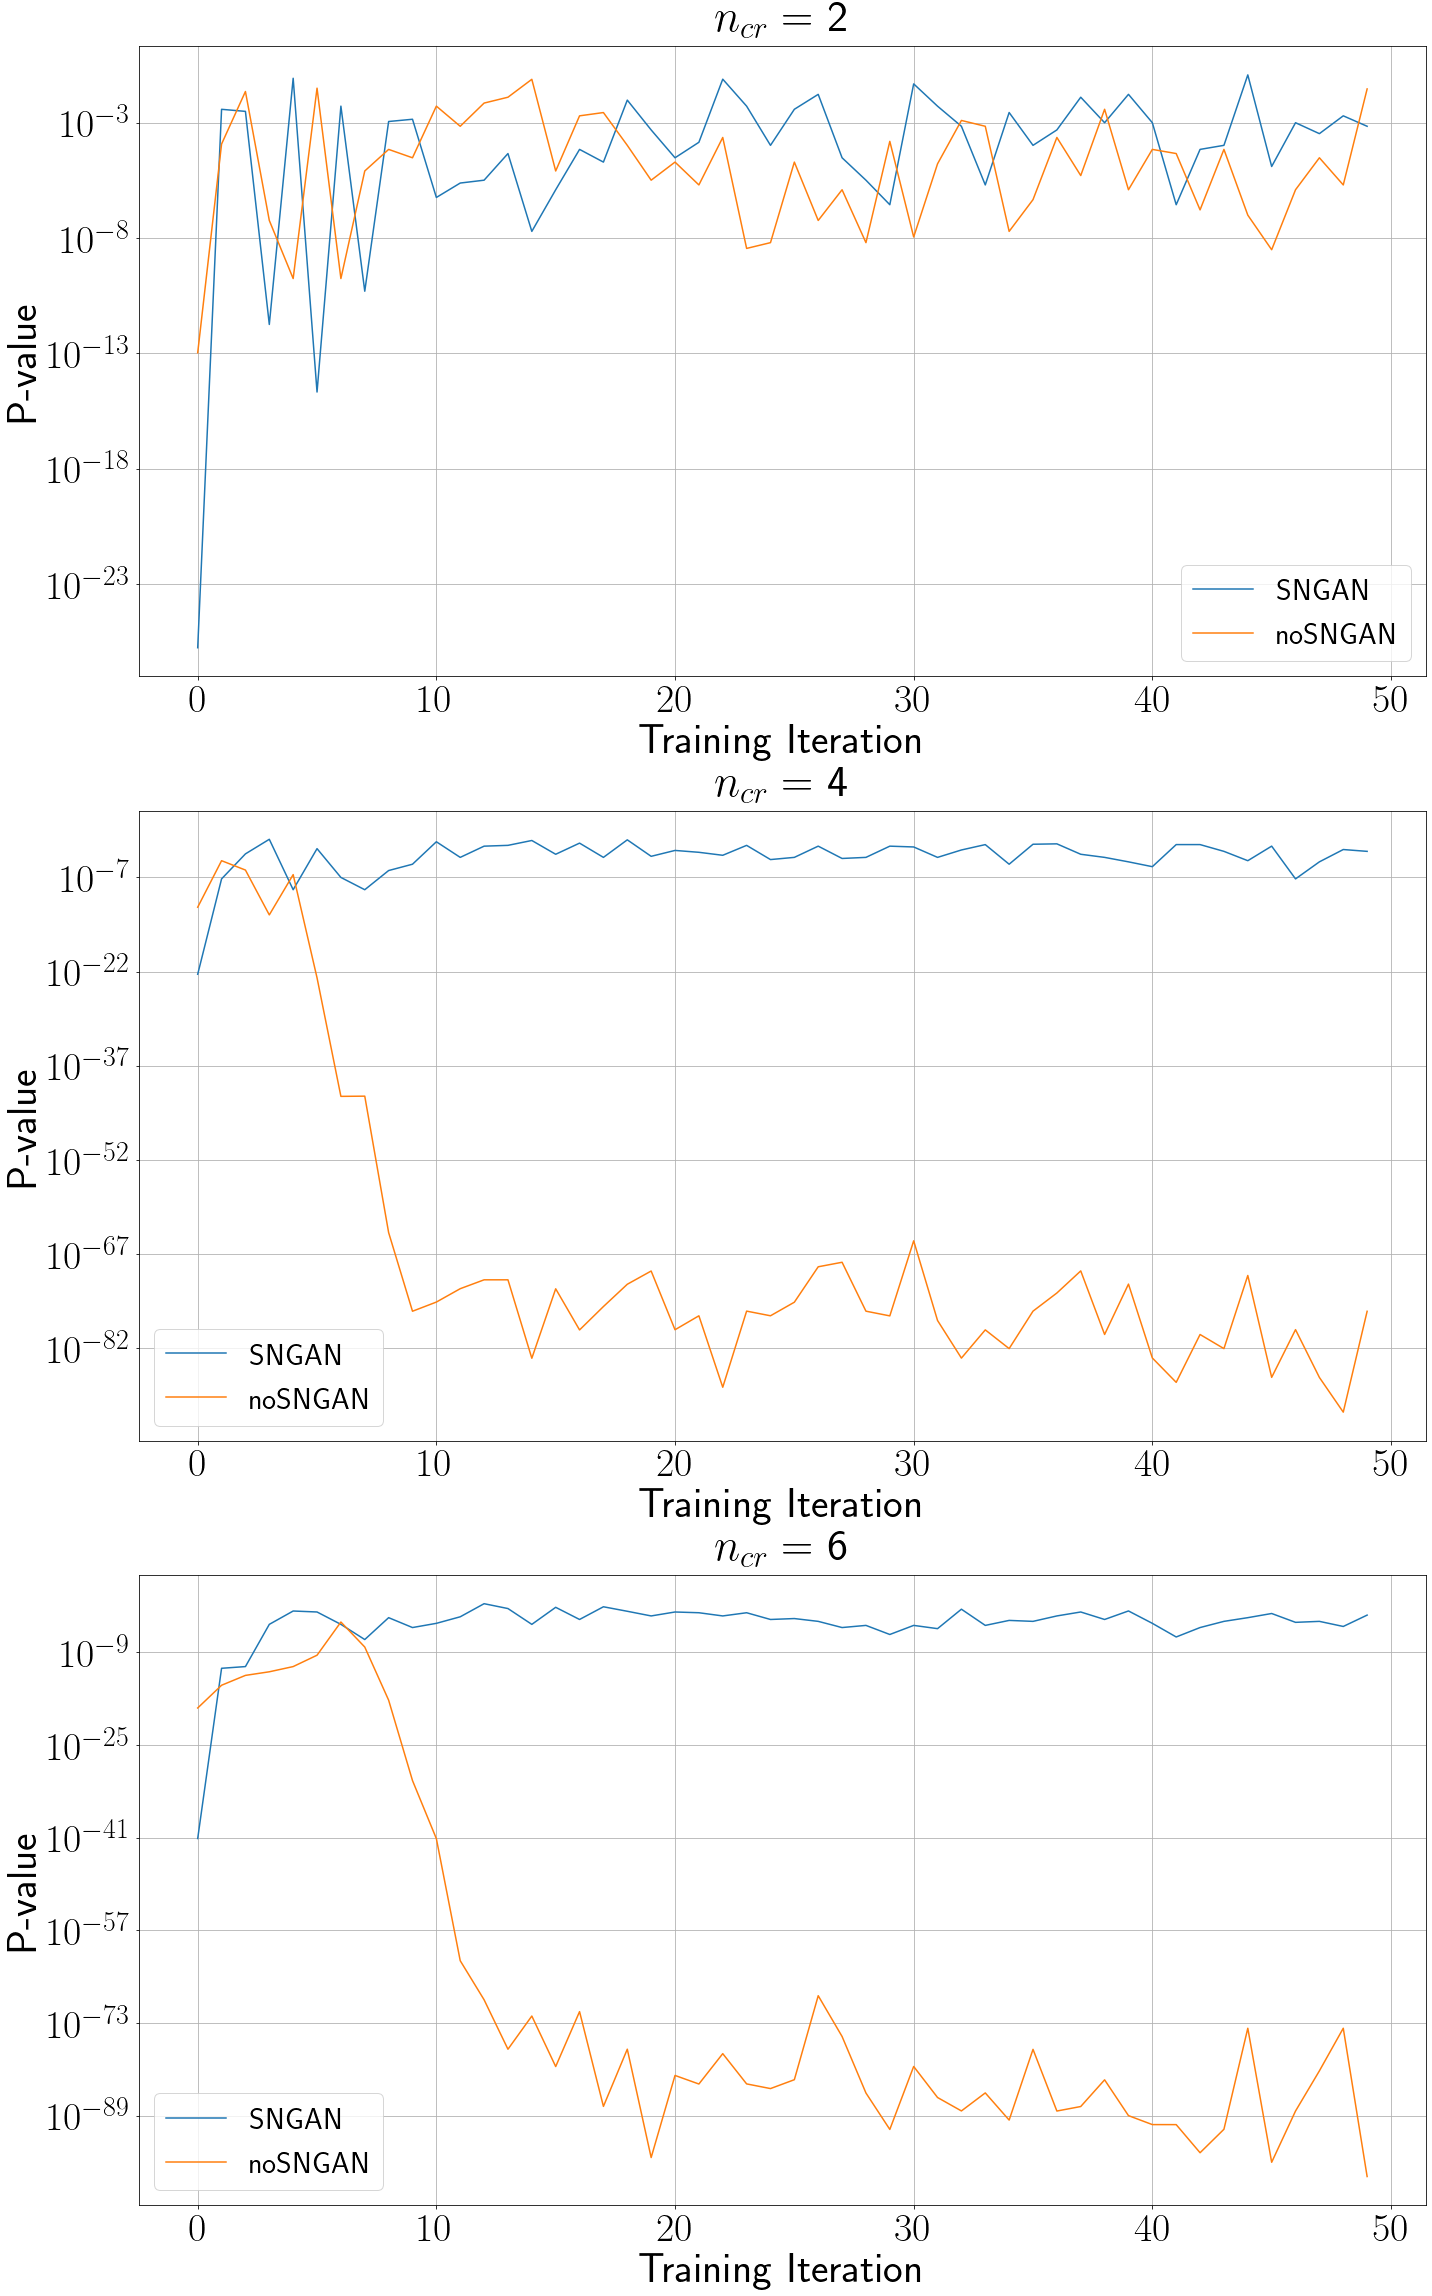

In [7]:
plt.figure(figsize=(20, 32))
ax = {}
ax[2]=plt.subplot(3, 1, 1)
ax[4]=plt.subplot(3, 1, 2)
ax[6]=plt.subplot(3, 1, 3)
for n_cr in [2, 4, 6]:
    ax[n_cr].set_title("$n_{cr}= $"+f" {n_cr}", fontsize=45)
    ax[n_cr].semilogy(np.load(f"results/sn_ncr{n_cr}/data.npy"), label=f"SNGAN")
    ax[n_cr].semilogy(np.load(f"results/ncr{n_cr}/data.npy"), label=f"noSNGAN")
    ax[n_cr].set_xlabel('Training Iteration',fontsize=42)
    ax[n_cr].set_ylabel('P-value',fontsize=42)
    ax[n_cr].tick_params(axis="x", labelsize=40)
    ax[n_cr].tick_params(axis="y", labelsize=40)
    ax[n_cr].grid()
    ax[n_cr].legend(fontsize=30)
    
savefig("results/compare_pval.pdf")

In [ ]:
np.save("results/big6.pkl", train_losses["pvals"])

In [ ]:
np.array(train_losses["pvals"]).mean()

In [ ]:
from scipy import stats
pvalue = {}

In [ ]:
for key, generator in g.items():
    pvalue[key] = []
    for _ in range(100):
        data1 = generator.sample(500).detach().numpy()
        data2 = experiment_data(n=500, n_modes=n_modes, params=params)
        pvalue[key].append(stats.ks_2samp(data1.T[0], data2.T[0])[1])

In [ ]:
for p in pvalue:
    print(max(pvalue[p]))

In [ ]:
plt.figure(figsize=(20, 10))
for p in pvalue:
    plt.grid()
    plt.hist(pvalue[p], label=f"n_cr = {p}", bins=30)
    plt.legend()
savefig("results/hist.pdf")

In [ ]:
def exp1(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    g = Generator(3, 1, 5, 1).to(ptu.device)
    c = Discriminator(1, 4, 20, 1).to(ptu.device)

    # wasserstein
    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return critic(fake_data).mean() - critic(x).mean() # + 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 200
    c_opt = optim.Adam(c[n_cr].parameters(), lr=9e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g[n_cr].parameters(), lr=9e-5, betas=(0, 0.9))
    train_args = {
        "epochs": n_epochs, 
        "n_critic": n_cr, 
        "final_snapshot":True,
    }
    result = train_epochs(g[n_cr], c[n_cr], g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=False, modes=n_modes, name=f"more_epoch{n_cr}", param_modes=params) #, g_scheduler=g_scheduler, c_scheduler=c_scheduler)
    train_losses, samples_1, samples_final = result
    return g, c, train_losses, samples_1, samples_final

start = time.time()
g, c, train_losses, samples_1, samples_final = experiment_save_results('a', exp1, f"more_epoch{n_cr}", 
                                                                       is_spiral=False,
                                                                       modes=n_modes,
                                                                       param_modes=params)
end = time.time()

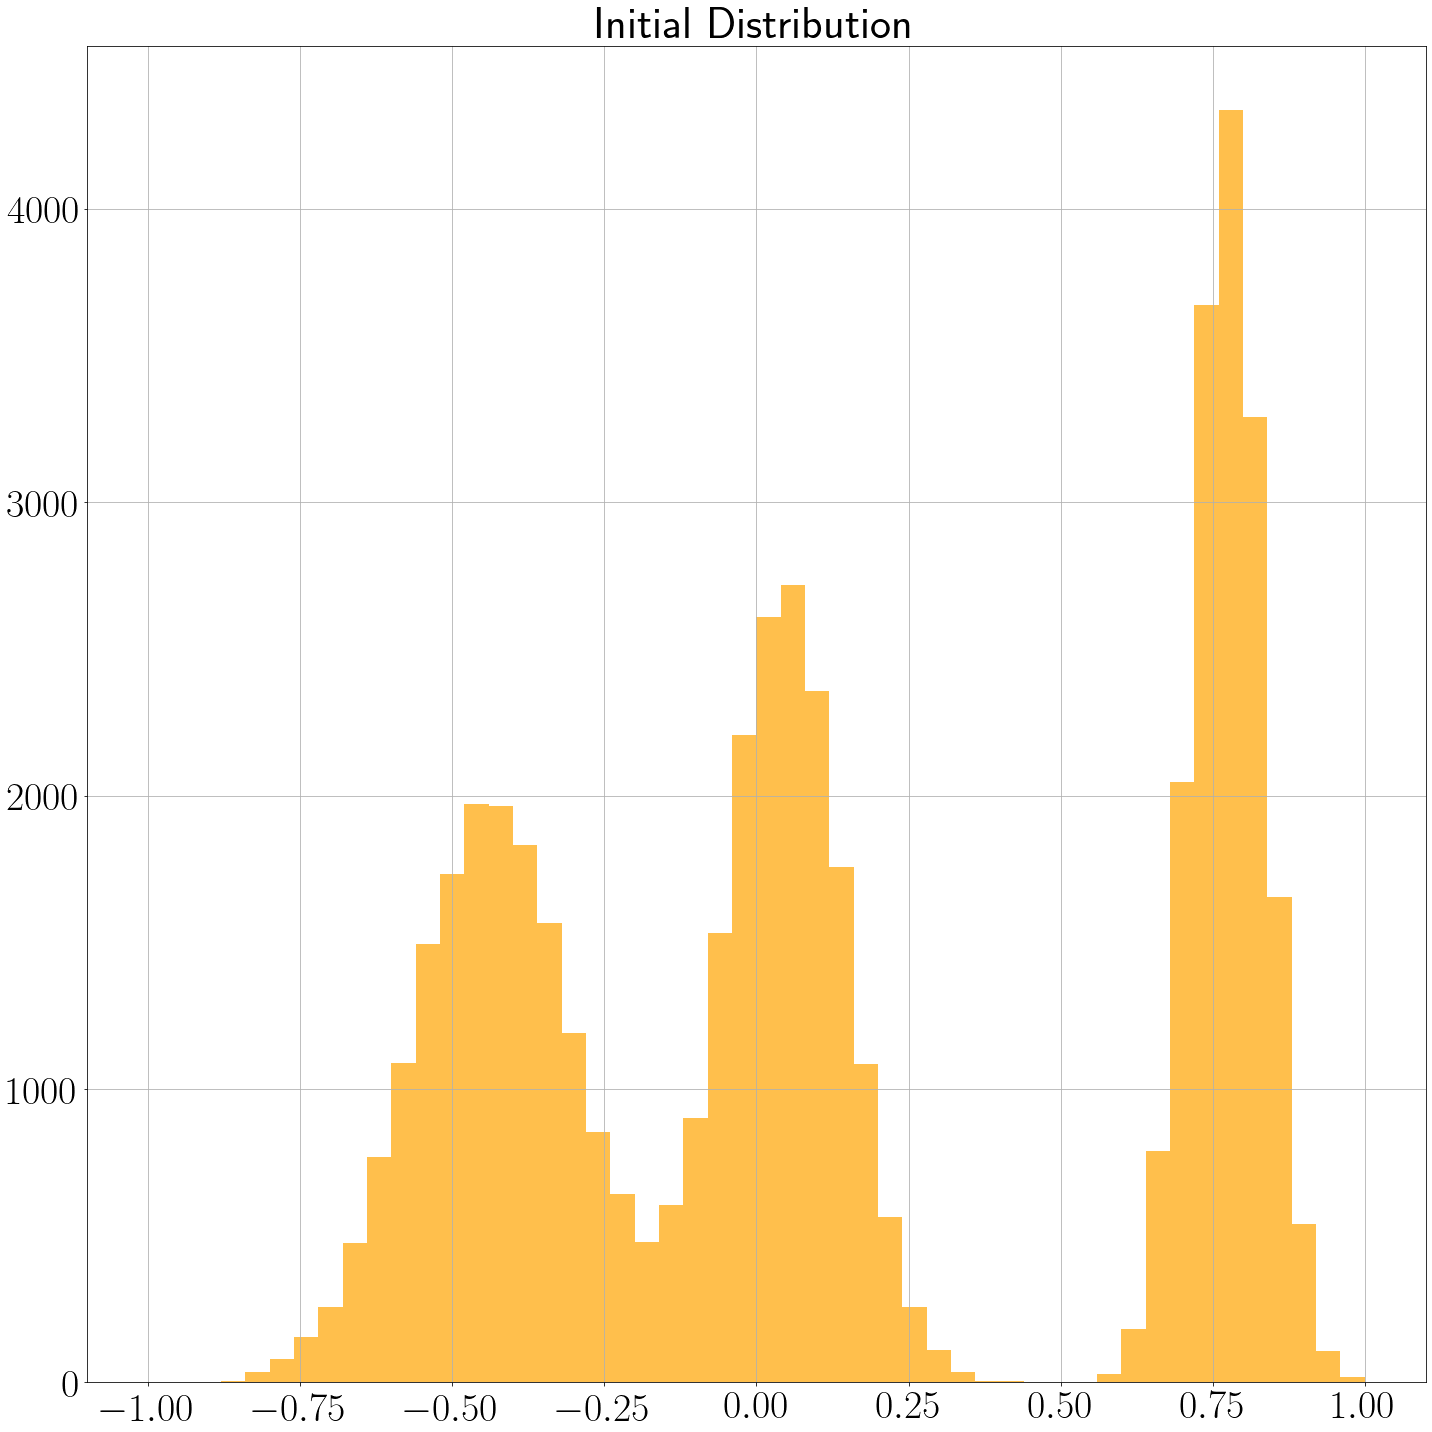

In [5]:
visualize_experiment_dataset(is_spiral=False, modes=n_modes, param_modes=params)

In [ ]:
start = time.time()
g, c, train_losses, samples_1, samples_final = experiment_save_results('a', exp1, "sn_ncr2", 
                                                                       is_spiral=False,
                                                                       modes=n_modes,
                                                                       param_modes=params)
end = time.time()
delta.append(end-start)

In [ ]:
!ls

In [ ]:
np.save("./saved_samples/exp1_n_r=2_nosn", g.sample(2000).detach().numpy())

In [47]:
delta

{2: 234.82655310630798, 4: 209.77042508125305, 6: 205.16864585876465}

> Формула для спирали $r(\theta) = a+b\theta$

In [ ]:
a = experiment_data(n=1, is_spiral=True, n_modes=3, params=params)

In [ ]:
visualize_experiment_dataset(is_spiral=True)

In [ ]:
def exp2(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    
    g = Generator(10, 7, 50, 2).to(ptu.device)
    c = Discriminator(2, 4, 30, 1).to(ptu.device)


    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - critic(fake_data).mean()
    
    def c_loss(generator, critic, x):
        batch_size = x.shape[0]
        fake_data = generator.sample(batch_size)
        return critic(fake_data).mean() - critic(x).mean() #- 0.1 * penalty(generator, critic, x, fake_data)
    n_epochs = 500

    c_opt = optim.Adam(c.parameters(), lr=9e-5, betas=(0, 0.9))
    g_opt = optim.Adam(g.parameters(), lr=9e-5, betas=(0.5, 0.9))
#     c_scheduler = torch.optim.lr_scheduler.StepLR(c_opt, step_size=250, gamma=0.8)
#     g_scheduler = torch.optim.lr_scheduler.StepLR(g_opt, step_size=200, gamma=0.9)
    train_args = {
        "epochs": n_epochs, 
        "n_critic": 5, 
        "final_snapshot":True
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, 
                          c_opt=c_opt, is_spiral=True, name="spiralsncr2")
    train_losses, samples_1, samples_final = result
    return g, c, train_losses['c_losses'], samples_1, samples_final

In [ ]:
start = time.time()
g, c, *_ = experiment_save_results('a', exp2, 'spiral', is_spiral=True)
end = time.time()
delta.append(end-start)

> 100 epochs, no Spectral Noramlization , $n_{cr} = 2, t = 183.73s$

> 100 epochs, no Spectral Noramlization , $n_{cr} = 4, t = 180.28s$

> 100 epochs, no Spectral Noramlization , $n_{cr} = 4, t = 168.17s$

> 100 epochs, Spectral Noramlization , $n_{cr} = 2, t = 260.13s$

> 100 epochs, Spectral Noramlization , $n_{cr} = 4, t = 234.86s$

> 100 epochs, Spectral Noramlization , $n_{cr} = 6, t = 233.38s$